In [1]:
import os
import sys
import time

import IPython
from IPython import display

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from scipy import stats

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#ML libraries
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import warnings
#warnings.filterwarnings(action='once')
warnings.simplefilter("ignore")
#warnings.simplefilter("default")

In [2]:
#Getting and cleaning data
data_raw = pd.read_csv('../Titanic/train.csv')
data_val  = pd.read_csv('../Titanic/test.csv')
data1 = data_raw.copy(deep = True)
data_cleaner = [data1, data_val]

print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S
420,421,0,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S
397,398,0,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S
215,216,1,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
467,468,0,1,"Smart, Mr. John Montgomery",male,56.0,0,0,113792,26.5500,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S


In [3]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')


Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Chip, Mr. Chang",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
#Completing or deleting rows with missing values

for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete features that will be excluded from the model
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
#Feature engineering
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1  #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    dataset['Title']=dataset['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

    

In [6]:
#Cleaning rare titles
#print(data1['Title'].value_counts())
freq_min=10
rare_titles= (data1['Title'].value_counts())<freq_min
data1['Title']=data1['Title'].apply(lambda x: 'Misc' if rare_titles.loc[x]==True else x)
print(data1['Title'].value_counts())
print("-"*10)
data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
700,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,227.5250,C,2,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"
135,0,2,"Richard, Mr. Emile",male,23.0,0,0,15.0458,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
653,1,3,"O'Leary, Miss. Hanora ""Norah""",female,28.0,0,0,7.8292,Q,1,1,Miss,"(-0.001, 7.91]","(16.0, 32.0]"
639,0,3,"Thorneycroft, Mr. Percival",male,28.0,1,0,16.1000,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
375,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,28.0,1,0,82.1708,C,2,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"
312,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,26.0000,S,3,0,Mrs,"(14.454, 31.0]","(16.0, 32.0]"
733,0,2,"Berriman, Mr. William John",male,23.0,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
512,1,1,"McGough, Mr. James Robert",male,36.0,0,0,26.2875,S,1,1,Mr,"(14.454, 31.0]","(32.0, 48.0]"
425,0,3,"Wiseman, Mr. Phillippe",male,28.0,0,0,7.2500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
411,0,3,"Hart, Mr. Henry",male,28.0,0,0,6.8583,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"


In [7]:
#Conversion of categorical features into numbers
label=LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

#define y variable aka target/outcome
Target = ['Survived']

#define x variables for feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation

data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')

#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



In [8]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null catego

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Chip, Mr. Chang",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
#Split train and test data
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)

train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)

train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()


Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [10]:
#Discrete Variable Correlation by Survival using pandas grouping
discrete_x=[x for x in data1_x if (data1[x].dtype!= 'float64')]

for x in discrete_x:
    print("\nCorrelation for {}\n".format(x))
    print(data1[[x, Target[0]]].groupby(x).mean())
    print("-"*10)

print("\nPrinting crosstab for title survival\n")
print(pd.crosstab(data1['Title'],data1[Target[0]]))


Correlation for Sex

        Survived
Sex             
female  0.742038
male    0.188908
----------

Correlation for Pclass

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
----------

Correlation for Embarked

          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009
----------

Correlation for Title

        Survived
Title           
Master  0.575000
Misc    0.444444
Miss    0.697802
Mr      0.156673
Mrs     0.792000
----------

Correlation for SibSp

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
----------

Correlation for Parch

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
----------

Correlation for FamilySize

            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431

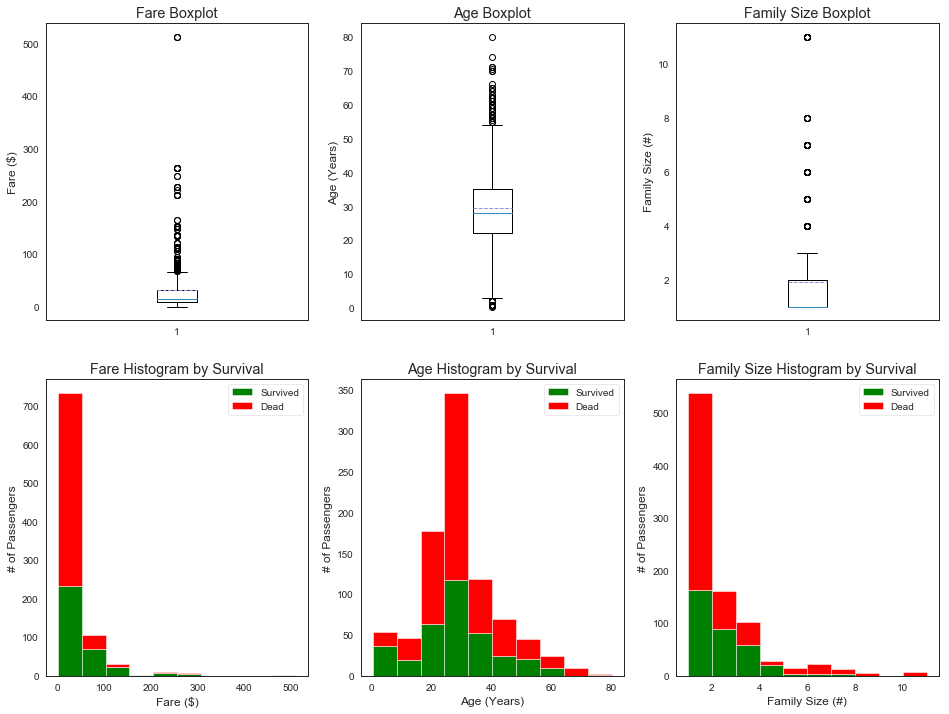

In [11]:
#VISUALIZATION AND ANALYSIS
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

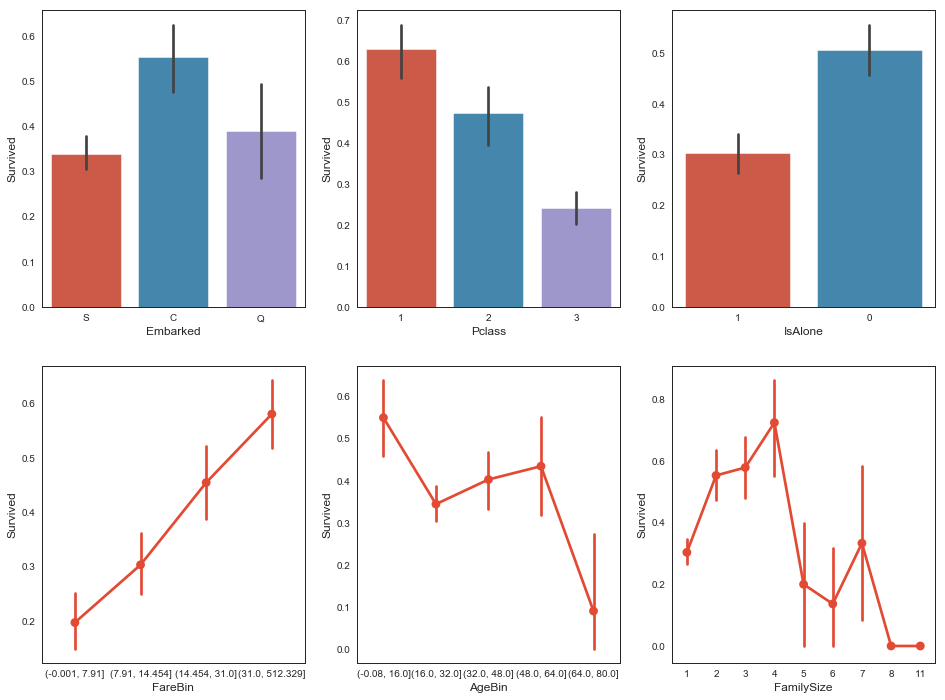

In [12]:
#Multivariate analysis

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=tuple([1,2,3]), data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=tuple([1,0]), data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5, 1.0, 'Pclass vs FamilySize Survival Comparison')

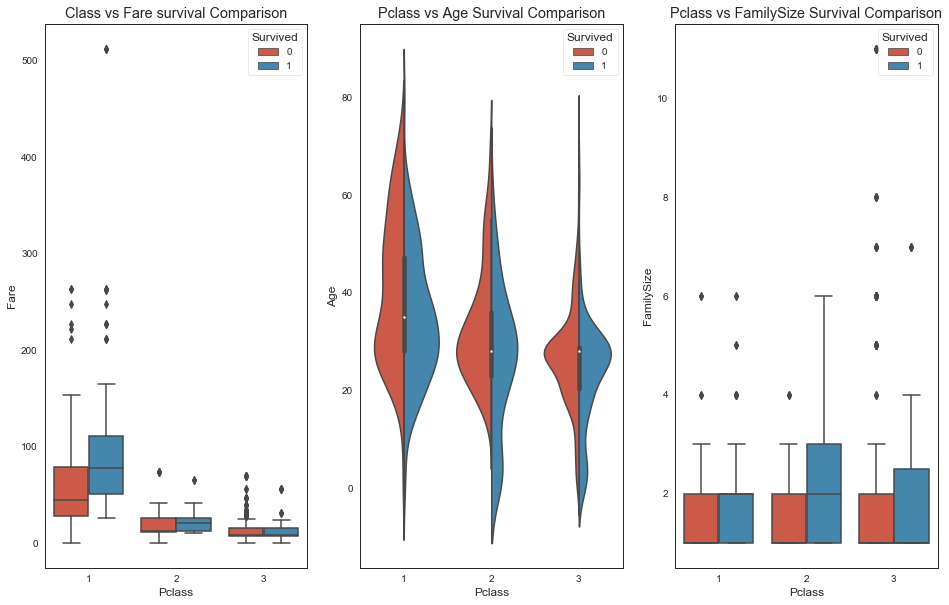

In [13]:
#graph distribution of Pclass qualitative data:
#class mattered in survival, si let's compare it with a 2nd feature

fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(16,10))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', ax=axis1, data=data1)
axis1.set_title('Class vs Fare survival Comparison')
sns.violinplot(x='Pclass', y='Age', hue='Survived', ax=axis2, data=data1, split=True)
axis2.set_title('Pclass vs Age Survival Comparison')
sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', ax=axis3, data=data1)
axis3.set_title('Pclass vs FamilySize Survival Comparison')


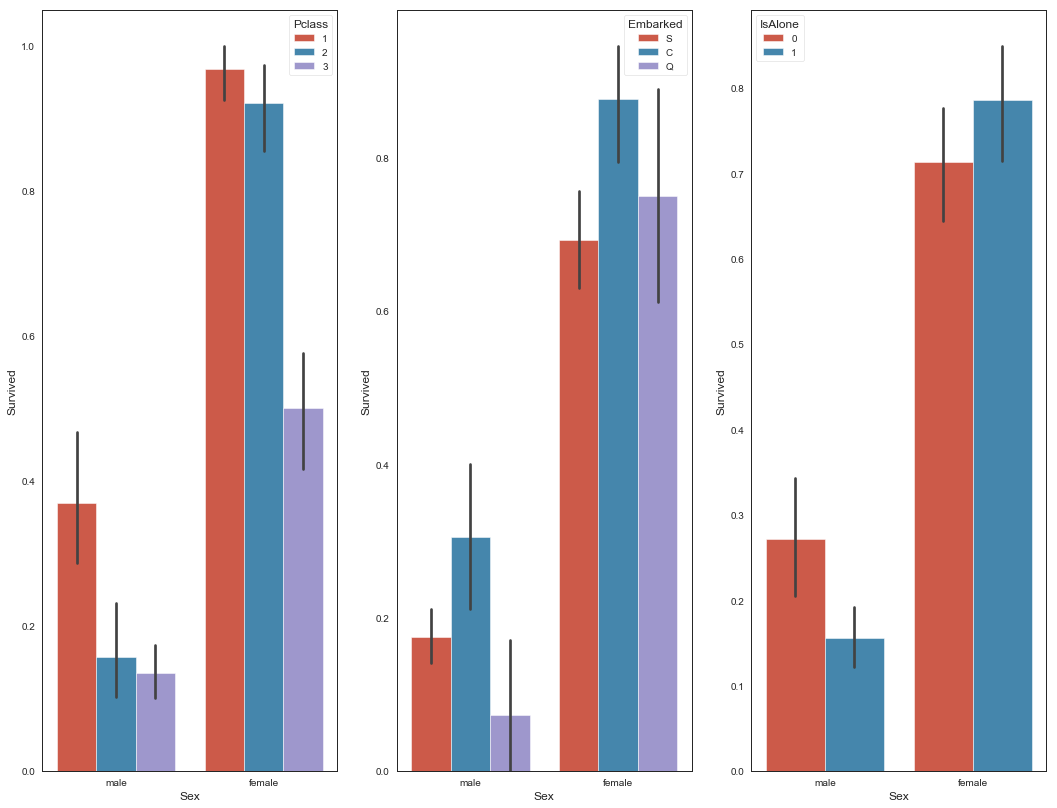

In [14]:
#graph distribution of qualitative data: Sex
#comparing sex and a 2nd feature

fig, qaxis= plt.subplots(1,3, figsize=(18,14))
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=data1, ax=qaxis[0])
sns.barplot(x='Sex', y='Survived', hue='Embarked', data=data1, ax=qaxis[1])
sns.barplot(x='Sex', y='Survived', hue='IsAlone', data=data1, ax=qaxis[2])

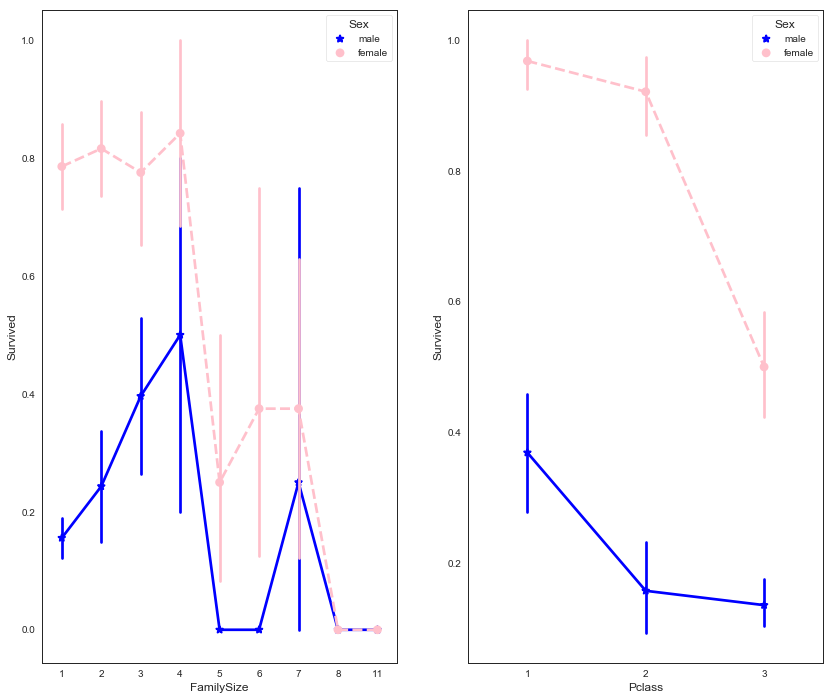

In [15]:
#some more comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare

sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=data1, ax=maxis1,
             palette={'male' : 'blue', 'female' : 'pink'},
             markers=['*', 'o'], linestyles=['-', '--'])

#how does class factor with sex & survival compare

sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=data1, ax=maxis2,
             palette= {'male' : 'blue', 'female': 'pink'},
             markers=['*','o'], linestyles=['-','--'])


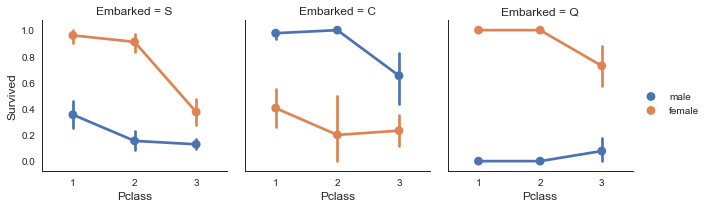

In [16]:
#how does embark port factor with class, sex, and survival compare
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

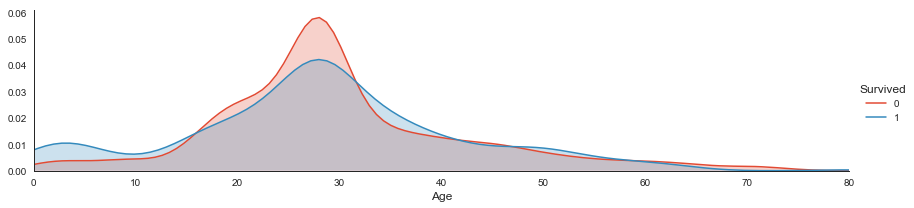

In [17]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

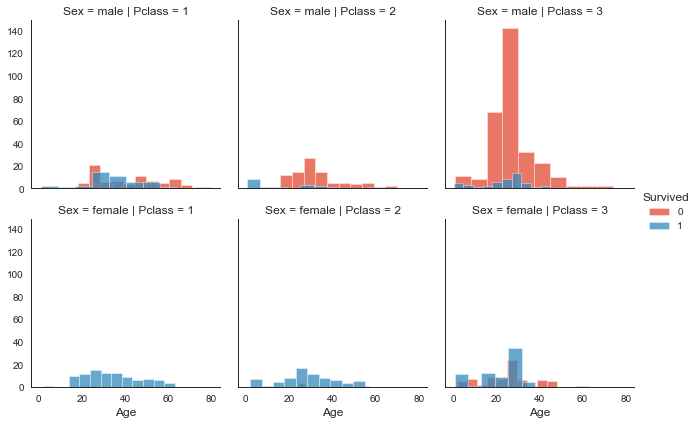

In [18]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

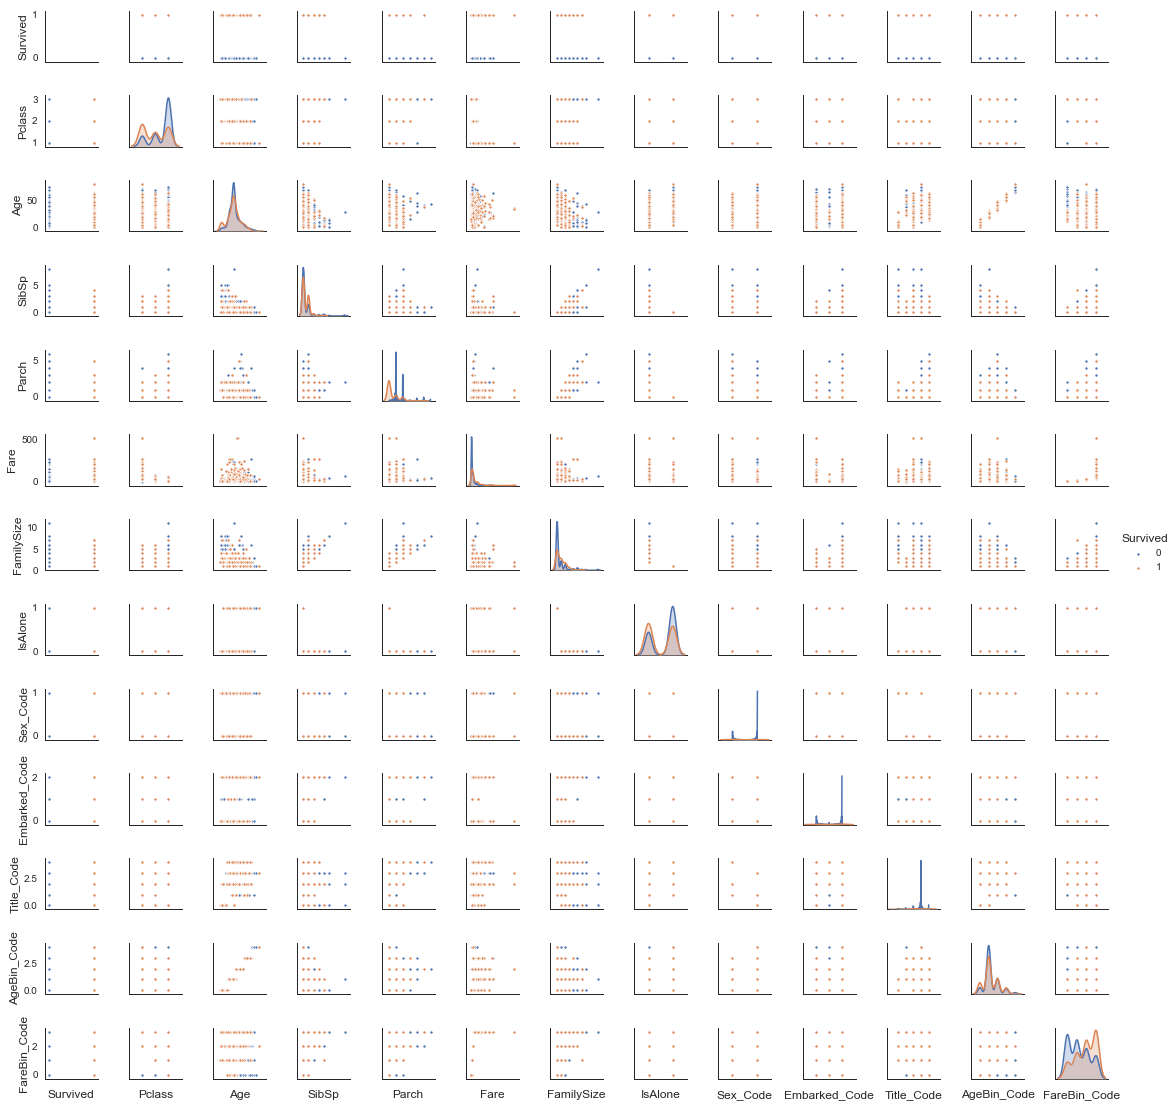

In [19]:
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', height=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

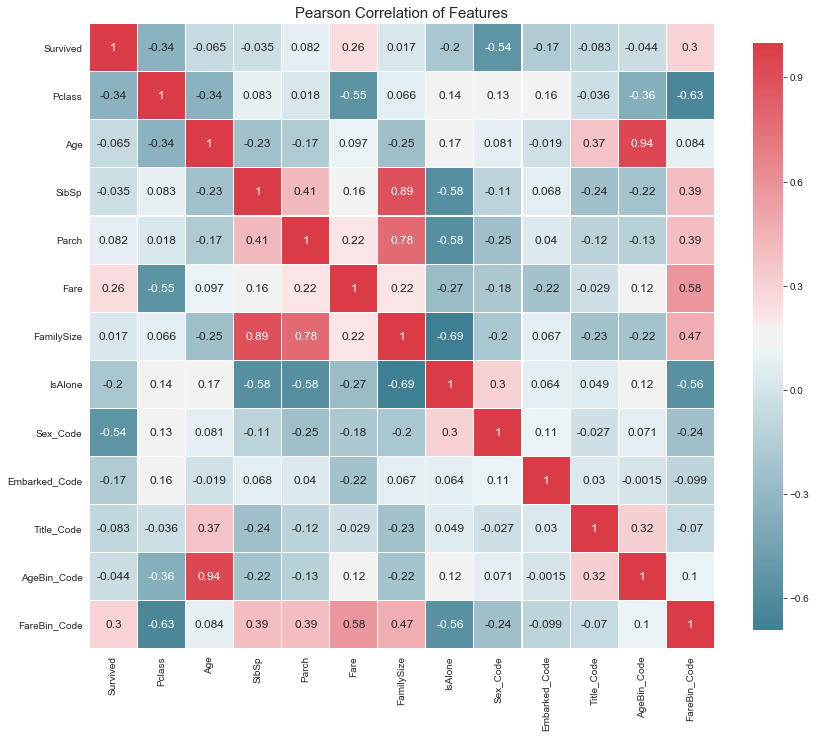

In [20]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

In [21]:
#Machine Learning Algorithm Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True, gamma='auto'),
    svm.NuSVC(probability=True, gamma='auto'),
    svm.LinearSVC(max_iter=100000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier()    
    ]

#splitting dataset in cross-validation 

# run model 10x with 60/30 split, leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target].values.ravel(), cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #calculate and save MLA predictions
    alg.fit(data1[data1_x_bin], data1[Target].values.ravel())
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.04212
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.839139,0.828731,0.0576139,0.008796
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0401519
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0454312
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.822015,0.0500737,0.00183334
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.8897,0.820522,0.0827829,0.0136389
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.820149,0.072338,0.0103642
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891386,0.81903,0.0639629,0.0109937
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.827903,0.816791,0.0526119,0.0137739
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00183523


Text(0, 0.5, 'Algorithm')

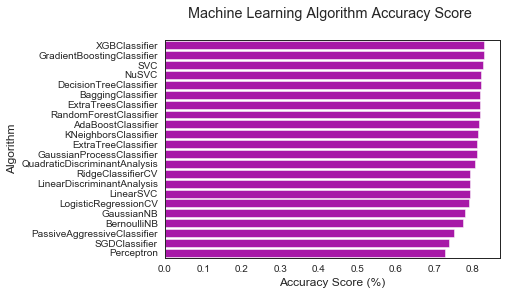

In [23]:
#barplot using seaborn
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [25]:
#Tuning model hyper-parameters

dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

#tuning 
param_grid = {'criterion': ['gini', 'entropy'],              
              #'splitter': ['best', 'random'],
              'max_depth': [2,4,6,8,10,None],
              #'min_samples_split': [2,5,10,.03,.05],
              #'min_samples_leaf': [1,5,10,.03,.05], 
              #'max_features': [None, 'auto'], 
              'random_state': [0] 
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


#duplicates gridsearchcv
#tune_results = model_selection.cross_validate(tune_model, data1[data1_x_bin], data1[Target], cv  = cv_split)

#print('AFTER DT Parameters: ', tune_model.best_params_)
#print("AFTER DT Training w/bin set score mean: {:.2f}". format(tune_results['train_score'].mean()*100)) 
#print("AFTER DT Test w/bin set score mean: {:.2f}". format(tune_results['test_score'].mean()*100))
#print("AFTER DT Test w/bin set score min: {:.2f}". format(tune_results['test_score'].min()*100))
#print('-'*10)


BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


In [26]:
#Tuning model with feature selection

#base model
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


#Graph MLA version of Decision Tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz 
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

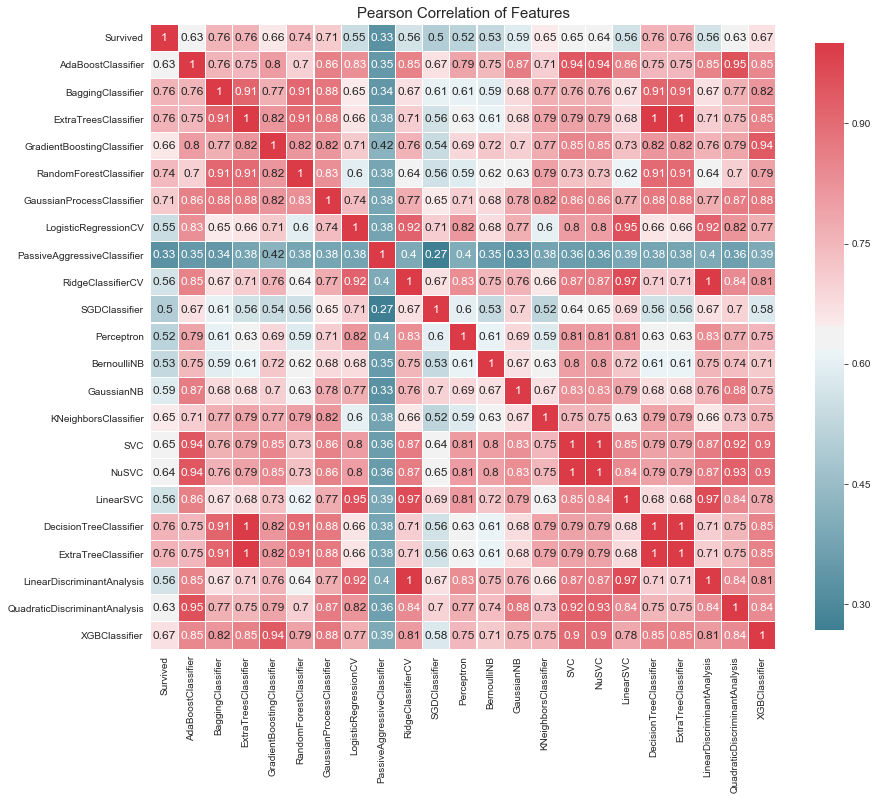

In [28]:
#Validate and implement

#compare algorithm predictions with each other
correlation_heatmap(MLA_predict)